In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Ensemble

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def _normalize_tabular(df: pd.DataFrame, label_name: str = "label"):
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(label_name, axis=1))
    y = df[label_name]
    return X, y

def simul_split_train_valid_test(df: pd.DataFrame, train_ratio: float = 0.7):
    X, y = _normalize_tabular(df)
    tmp = pd.DataFrame(X)
    tmp["label"] = y
    normal = tmp.loc[tmp["label"] == 0, :].reset_index(drop=True)
    abnormal = tmp.loc[tmp["label"] == 1, :].reset_index(drop=True)
    X_train, X_val_test, y_train, y_val_test = train_test_split(
        normal.drop("label", axis=1),
        normal["label"],
        train_size=train_ratio,
        random_state=42,
        shuffle=False,
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, train_size=0.5, random_state=42, shuffle=False
    )
    X_test["label"] = y_test
    X_test = pd.concat([X_test, abnormal]).reset_index(drop=True)
    return (
        X_train.values,
        X_val.values,
        X_test.drop("label", axis=1).values,
        y_train.values,
        y_val.values,
        X_test["label"].values,
    )

In [3]:
os.listdir('./tabular_data')

['abalone9-18.csv',
 'shuttle-c0-vs-c4.csv',
 'vowel0.csv',
 'wine.csv',
 'yeast-1-2-8-9_vs_7.csv',
 'yeast4.csv',
 'yeast5.csv',
 'yeast6.csv']

In [4]:
def get_ensemble_result(ensemble_PATH='./ensemble_sim_1/', data_path='./sim_data/', name='smallNormal.csv', n_models=8):
    data = pd.read_csv(data_path + name)

    (
        _,
        _,
        _,
        _,
        _,
        test_y,
    ) = simul_split_train_valid_test(data, 0.7)

    name = name.split('.')[0]

    anomaly_score = np.zeros((len(test_y), n_models))

    result_df = pd.DataFrame(columns=['mean','median','max','min'], index=['roc_auc','pr_auc'])


    idx = 0
    for data_name in os.listdir(ensemble_PATH):
        if name in data_name:
            with open(ensemble_PATH + data_name, 'rb') as f:
                tmp = pickle.load(f)
                anomaly_score[:, idx] = tmp
                idx += 1

    tst_ano_scr_med = np.median(anomaly_score, axis=1)
    tst_ano_scr_mean = np.mean(anomaly_score, axis=1)
    tst_ano_scr_max = np.max(anomaly_score, axis=1)
    tst_ano_scr_min = np.min(anomaly_score, axis=1)

    idx = 0
    for tst_ano_scr in [tst_ano_scr_mean, tst_ano_scr_med, tst_ano_scr_max, tst_ano_scr_min]:
        roc_auc = roc_auc_score(test_y, tst_ano_scr)
        _precision, _recall, _ = precision_recall_curve(test_y, tst_ano_scr)
        pr_auc = auc(_recall, _precision)
        result_df.iloc[0, idx] = roc_auc
        result_df.iloc[1, idx] = pr_auc
        idx += 1

    return result_df

# def get_ensemble_result_big(PATHs = ['./ensemble_sim_1/'], name = 'smallNormal.csv', n_models=8):
#     data = pd.read_csv('./sim_data/'+ name)

#     (
#         _,
#         _,
#         _,
#         _,
#         _,
#         test_y,
#     ) = simul_split_train_valid_test(data, 0.7)

#     name = name.split('.')[0]

#     anomaly_score = np.zeros((len(test_y), n_models * len(PATHs)))

#     result_df = pd.DataFrame(columns=['mean','median','max','min'], index=['roc_auc','pr_auc'])


#     idx = 0
#     for PATH in PATHs:
#         for data_name in os.listdir(PATH):
#             if name in data_name:
#                 with open(PATH + data_name, 'rb') as f:
#                     tmp = pickle.load(f)
#                     anomaly_score[:, idx] = tmp
#                     idx += 1

#     tst_ano_scr_med = np.median(anomaly_score, axis=1)
#     tst_ano_scr_mean = np.mean(anomaly_score, axis=1)
#     tst_ano_scr_max = np.max(anomaly_score, axis=1)
#     tst_ano_scr_min = np.min(anomaly_score, axis=1)

#     idx = 0
#     for tst_ano_scr in [tst_ano_scr_mean, tst_ano_scr_med, tst_ano_scr_max, tst_ano_scr_min]:
#         roc_auc = roc_auc_score(test_y, tst_ano_scr)
#         _precision, _recall, _ = precision_recall_curve(test_y, tst_ano_scr)
#         pr_auc = auc(_recall, _precision)
#         result_df.iloc[0, idx] = roc_auc
#         result_df.iloc[1, idx] = pr_auc
#         idx += 1

#     return result_df

In [5]:
PATH = ['./ensemble_sim_1/', './ensemble_sim_2/',  './ensemble_sim_3/']
name = 'smallTestNoise_010_09.csv'
result_df = get_ensemble_result_big(PATH, name)
result_df

NameError: name 'get_ensemble_result_big' is not defined

# Base & New Trainer

In [9]:
os.listdir('./run_result_tabular')

['result_abalone9-18.csv',
 'result_shuttle-c0-vs-c4.csv',
 'result_vowel0.csv',
 'result_wine.csv',
 'result_yeast-1-2-8-9_vs_7.csv',
 'result_yeast4.csv',
 'result_yeast5.csv',
 'result_yeast6.csv']

In [18]:
data_name = 'result_yeast6.csv'
tmp = pd.read_csv('./run_result_tabular/' + data_name)
base = tmp.loc[tmp['trainer_name']=='BaseTrainer', ['roc_auc','pr_auc']]
new = tmp.loc[tmp['trainer_name']=='NewTrainer',  ['roc_auc','pr_auc']]

base_roc = round(base.sort_values('roc_auc', ascending=False).head(10)['roc_auc'].mean(), 4)
new_roc  = round(new.sort_values('roc_auc', ascending=False).head(10)['roc_auc'].mean(), 4)
base_pr  = round(base.sort_values('pr_auc', ascending=False).head(10)['pr_auc'].mean(), 4)
new_pr   = round(new.sort_values('pr_auc', ascending=False).head(10)['pr_auc'].mean(), 4)

print(data_name)
print(f'base_roc={base_roc}')
print(f'new_roc={new_roc}')
print(f'base_pr={base_pr}')
print(f'new_pr={new_pr}')


result_yeast6.csv
base_roc=0.6638
new_roc=0.7139
base_pr=0.2073
new_pr=0.248


# bolxplot
- 데이터 마다 boxplot으로 new, ensemble score

In [5]:
ensemble_paths = ['./ensemble_sim_1/', './ensemble_sim_2/',  './ensemble_sim_3/']
single_path = './run_result_sim/'
single_n = -1
data_list = [d for d in os.listdir('./sim_data') if 'small' in d and '05' not in d and '.csv' in d]
method = 'min'

def get_boxplot_df(ensemble_paths, data_path, single_path, single_n, data_list, method):
    df = pd.DataFrame(columns=['model', 'data','score','value'])
    for data_name in data_list:
        # ensemble
        for ensemble_path in ensemble_paths:
            result_df = get_ensemble_result(ensemble_path, data_path, data_name)
            for d in zip(result_df[method].index, result_df[method].values):
                df = df.append(
                    {
                        'model': 'ensemble' + '(' + method + ')',
                        'data': data_name,
                        'score': d[0],
                        'value': d[1]
                    },
                    ignore_index=True
                )
        # single
        single_df = pd.read_csv(single_path + 'result_' +  data_name)
        single_df = single_df.loc[single_df['trainer_name']=='NewTrainer',  ['roc_auc','pr_auc']]
        if single_n == -1:
            new_pr = single_df.sort_values('pr_auc', ascending=False)
            new_roc  = single_df.sort_values('roc_auc', ascending=False)
        else:
            new_pr = single_df.sort_values('pr_auc', ascending=False).head(single_n)
            new_roc  = single_df.sort_values('roc_auc', ascending=False).head(single_n)
        print(f'single model의 갯수 = {len(single_df)}')
        for pr_auc in new_pr['pr_auc']:
            df = df.append(
                    {
                        'model': 'single',
                        'data': data_name,
                        'score': 'pr_auc',
                        'value': pr_auc
                    },
                    ignore_index=True
                )
        for roc_auc in new_roc['roc_auc']:
                df = df.append(
                    {
                        'model': 'single',
                        'data': data_name,
                        'score': 'roc_auc',
                        'value': roc_auc
                    },
                    ignore_index=True
                )
    
    return df

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
ensemble_paths = ['./ensemble_sim_1/', './ensemble_sim_2/',  './ensemble_sim_3/']
data_path = './sim_data/'
single_path = './run_result_sim/'
single_n = len(ensemble_paths) * 8
data_list = [d for d in os.listdir('./sim_data') if 'small' in d and '05' not in d and '.csv' in d]
method = 'max'

df = get_boxplot_df(ensemble_paths,data_path, single_path, single_n, data_list, method)

single model의 갯수 = 56
single model의 갯수 = 48
single model의 갯수 = 36
single model의 갯수 = 40
single model의 갯수 = 43
single model의 갯수 = 41
single model의 갯수 = 39


In [65]:
df.groupby(['model','data','score']).mean()

value
model         data                       score            
ensemble(max) smallNormal.csv            pr_auc   0.625585
                                         roc_auc  0.699648
              smallTestNoise_010_01.csv  pr_auc   0.614299
                                         roc_auc  0.688736
              smallTestNoise_010_09.csv  pr_auc   0.595377
                                         roc_auc  0.665526
              smallTrainNoise_001_01.csv pr_auc   0.621280
                                         roc_auc  0.695163
              smallTrainNoise_001_09.csv pr_auc   0.623923
                                         roc_auc  0.697090
              smallTrainNoise_010_01.csv pr_auc   0.626848
                                         roc_auc  0.701831
              smallTrainNoise_010_09.csv pr_auc   0.598734
                                         roc_auc  0.671893
single        smallNormal.csv            pr_auc   0.705142
                                         roc_auc  0.757650
              smallTestNoise_010_01.csv  pr_auc   0.660087
                                         roc_auc  0.721325
              smallTestNoise_010_09.csv  pr_auc   0.639292
                                         roc_auc  0.694750
              smallTrainNoise_001_01.csv pr_auc   0.684554
                                         roc_auc  0.741192
              smallTrainNoise_001_09.csv pr_auc   0.667975
                                         roc_auc  0.727692
              smallTrainNoise_010_01.csv pr_auc   0.675967
                                         roc_auc  0.735946
              smallTrainNoise_010_09.csv pr_auc   0.642479
                                         roc_auc  0.705442

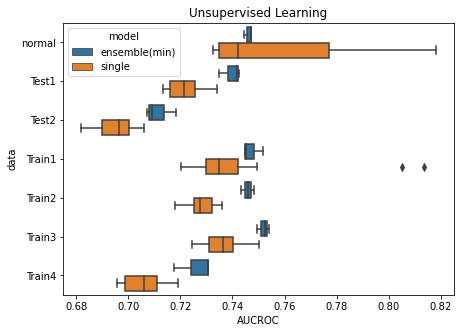

In [42]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df.loc[df['score']=='roc_auc', :], y='data', x='value',hue='model')
plt.yticks(np.arange(7), ['normal','Test1','Test2','Train1','Train2','Train3','Train4'])
plt.xlabel('AUCROC')
plt.title(f'Unsupervised Learning')
plt.show()

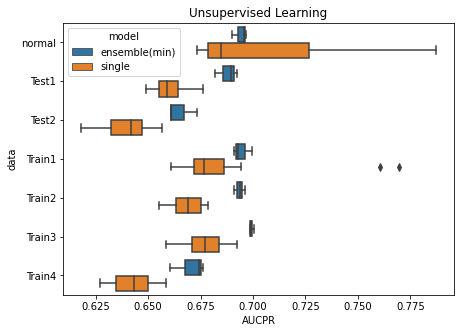

In [25]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df.loc[df['score']=='pr_auc', :], y='data', x='value',hue='model')
plt.yticks(np.arange(7), ['normal','Test1','Test2','Train1','Train2','Train3','Train4'])
plt.xlabel('AUCPR')
plt.title('Unsupervised Learning')
plt.show()

In [74]:
ensemble_paths = ['./ensemble_tabular_1/', './ensemble_tabular_2/',  './ensemble_tabular_3/']
data_path = './tabular_data/'
single_path = './run_result_tabular/'
single_n = len(ensemble_paths) * 8
data_list = os.listdir('./tabular_data')
method = 'min'

tabular_df = get_boxplot_df(ensemble_paths, data_path, single_path, single_n, data_list, method)

single model의 갯수 = 35
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24


In [75]:
tabular_df.groupby(['model','data','score']).mean()

value
model         data                   score            
ensemble(min) abalone9-18.csv        pr_auc   0.623803
                                     roc_auc  0.799756
              shuttle-c0-vs-c4.csv   pr_auc   1.000000
                                     roc_auc  1.000000
              vowel0.csv             pr_auc   0.633760
                                     roc_auc  0.680439
              wine.csv               pr_auc   0.422592
                                     roc_auc  0.726827
              yeast-1-2-8-9_vs_7.csv pr_auc   0.180754
                                     roc_auc  0.532206
              yeast4.csv             pr_auc   0.291928
                                     roc_auc  0.706065
              yeast5.csv             pr_auc   0.562800
                                     roc_auc  0.891251
              yeast6.csv             pr_auc   0.264845
                                     roc_auc  0.688685
single        abalone9-18.csv        pr_auc   0.588354
                                     roc_auc  0.777829
              shuttle-c0-vs-c4.csv   pr_auc   0.999962
                                     roc_auc  0.999983
              vowel0.csv             pr_auc   0.738254
                                     roc_auc  0.767654
              wine.csv               pr_auc   0.437296
                                     roc_auc  0.729754
              yeast-1-2-8-9_vs_7.csv pr_auc   0.183450
                                     roc_auc  0.538996
              yeast4.csv             pr_auc   0.283738
                                     roc_auc  0.687763
              yeast5.csv             pr_auc   0.518167
                                     roc_auc  0.887533
              yeast6.csv             pr_auc   0.225004
                                     roc_auc  0.684238

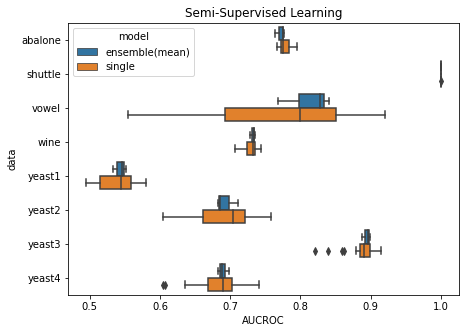

In [53]:
plt.figure(figsize=(7,5))
sns.boxplot(data=tabular_df.loc[tabular_df['score']=='roc_auc', :], y='data', x='value',hue='model')
plt.yticks(np.arange(8), ['abalone','shuttle','vowel','wine','yeast1','yeast2','yeast3','yeast4'])
plt.xlabel('AUCROC')
plt.title('Semi-Supervised Learning')
plt.show()

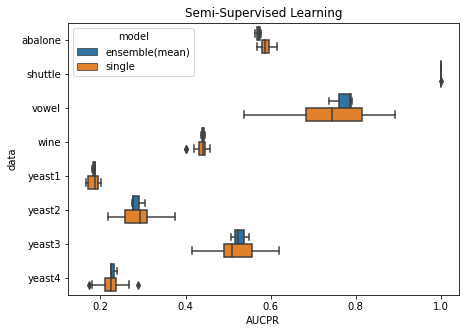

In [54]:
plt.figure(figsize=(7,5))
sns.boxplot(data=tabular_df.loc[tabular_df['score']=='pr_auc', :], y='data', x='value',hue='model')
plt.yticks(np.arange(8), ['abalone','shuttle','vowel','wine','yeast1','yeast2','yeast3','yeast4'])
plt.xlabel('AUCPR')
plt.title('Semi-Supervised Learning')
plt.show()

In [7]:
ensemble_paths = ['./ensemble_sim_1/', './ensemble_sim_2/',  './ensemble_sim_3/']
single_path = './run_result_sim/'
single_n = -1
data_list = [d for d in os.listdir('./sim_data') if 'small' in d and '05' not in d and '.csv' in d]
methods = ['min', 'max', 'max', 'median', 'max', 'min', 'median', 'max']

def get_boxplot_df_2(ensemble_paths, data_path, single_path, single_n, data_list, methods):
    df = pd.DataFrame(columns=['model', 'data','score','value'])
    i = 0
    for data_name in data_list:
        # ensemble
        for ensemble_path in ensemble_paths:
            result_df = get_ensemble_result(ensemble_path, data_path, data_name)
            for d in zip(result_df[methods[i]].index, result_df[methods[i]].values):
                df = df.append(
                    {
                        'model': 'ensemble',
                        'data': data_name,
                        'score': d[0],
                        'value': d[1]
                    },
                    ignore_index=True
                )
        i += 1
        # single
        single_df = pd.read_csv(single_path + 'result_' +  data_name)
        single_df = single_df.loc[single_df['trainer_name']=='NewTrainer',  ['roc_auc','pr_auc']]
        if single_n == -1:
            new_pr = single_df.sort_values('pr_auc', ascending=False)
            new_roc  = single_df.sort_values('roc_auc', ascending=False)
        else:
            new_pr = single_df.sort_values('pr_auc', ascending=False).head(single_n)
            new_roc  = single_df.sort_values('roc_auc', ascending=False).head(single_n)
        print(f'single model의 갯수 = {len(single_df)}')
        for pr_auc in new_pr['pr_auc']:
            df = df.append(
                    {
                        'model': 'single',
                        'data': data_name,
                        'score': 'pr_auc',
                        'value': pr_auc
                    },
                    ignore_index=True
                )
        for roc_auc in new_roc['roc_auc']:
                df = df.append(
                    {
                        'model': 'single',
                        'data': data_name,
                        'score': 'roc_auc',
                        'value': roc_auc
                    },
                    ignore_index=True
                )
    
    return df

single model의 갯수 = 35
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24


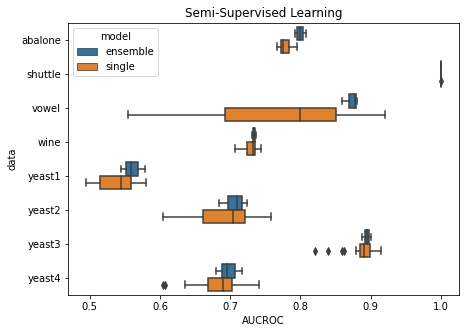

In [12]:
ensemble_paths = ['./ensemble_tabular_1/', './ensemble_tabular_2/',  './ensemble_tabular_3/']
data_path = './tabular_data/'
single_path = './run_result_tabular/'
single_n = len(ensemble_paths) * 8
data_list = os.listdir('./tabular_data')
methods = ['min', 'max', 'max', 'median', 'max', 'min', 'median', 'max']

tabular_df = get_boxplot_df_2(ensemble_paths, data_path, single_path, single_n, data_list, methods)

plt.figure(figsize=(7,5))
sns.boxplot(data=tabular_df.loc[tabular_df['score']=='roc_auc', :], y='data', x='value',hue='model')
plt.yticks(np.arange(8), ['abalone','shuttle','vowel','wine','yeast1','yeast2','yeast3','yeast4'])
plt.xlabel('AUCROC')
plt.title('Semi-Supervised Learning')
plt.show()

single model의 갯수 = 35
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24
single model의 갯수 = 24


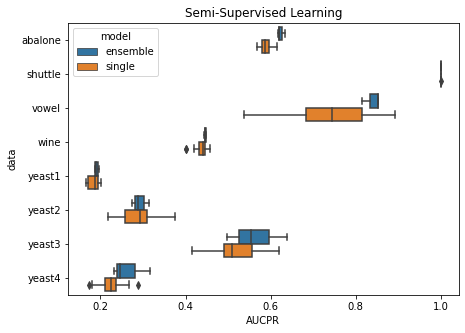

In [13]:
ensemble_paths = ['./ensemble_tabular_1/', './ensemble_tabular_2/',  './ensemble_tabular_3/']
data_path = './tabular_data/'
single_path = './run_result_tabular/'
single_n = len(ensemble_paths) * 8
data_list = os.listdir('./tabular_data')
methods = ['min', 'max', 'max', 'median', 'max', 'min', 'min', 'min']

tabular_df = get_boxplot_df_2(ensemble_paths, data_path, single_path, single_n, data_list, methods)

plt.figure(figsize=(7,5))
sns.boxplot(data=tabular_df.loc[tabular_df['score']=='pr_auc', :], y='data', x='value',hue='model')
plt.yticks(np.arange(8), ['abalone','shuttle','vowel','wine','yeast1','yeast2','yeast3','yeast4'])
plt.xlabel('AUCPR')
plt.title('Semi-Supervised Learning')
plt.show()